READING AND PREPARING DATA

In [1]:
# DATASET FROM KAGGLE Yoga Poses Dataset, only smaller, roughly cleaned up, dataset was used

from dotenv import load_dotenv
import os

load_dotenv()
dirname = os.path.dirname(os.getenv('PATH_TO_DATABASE'))

In [2]:
# LOADING IMAGES AND LABELS
import cv2

def load_images_from_folder(folder):
    images = []
    labels = []
    for foldername in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, foldername)):
            img = cv2.imread(os.path.join(folder, foldername, filename))
            if img is not None:
                img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_RGB)
                labels.append(foldername)
    return images, labels

images, labels_raw = load_images_from_folder(dirname)

In [3]:
# SHUFFLING DATA
import random

random.seed(10)
random.shuffle(images)
random.seed(10)
random.shuffle(labels_raw)

(<matplotlib.image.AxesImage at 0x214821d6bf0>, 'tree')

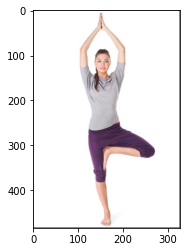

In [4]:
import matplotlib.pyplot as plt
plt.imshow(images[35]), labels_raw[35]

In [5]:
#SETTING UP MEDIA PIPE

import mediapipe as mp

mp_pose = mp.solutions.pose
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

In [6]:
# GETTING ONLY POSE RELATED LANDMARKS FROM MEDIAPIPE

def get_pose_arr(landmark_input):
    pose_only = landmark_input.pose_landmarks.landmark[10:-1]
    pose_arr = [[body_part.x, body_part.y, body_part.z, body_part.visibility] for body_part in pose_only]
    return pose_arr


In [7]:
# DETECTING POSE WITH MEDIAPIPE

def detect_pose(img, pose=pose_image):
    result = pose.process(img)
    if not result.pose_landmarks:
        return None
    else:
        return get_pose_arr(result)

In [8]:
pose_detected_images = []
labels = []
images_ordered = [] # For future visualization

for i in range(len(images)):
    pose_coordinates = detect_pose(images[i])

    if pose_coordinates is None: # If photo cant be processed by mediapipe
        print(f'Image no {i} does not work')

    else:
        pose_detected_images.append(pose_coordinates)
        labels.append(labels_raw[i]) # Easier than deleting items from array while looping
        images_ordered.append(images[i])

Image no 51 does not work
Image no 469 does not work


In [9]:
# GETTIN 3D POSITION ARRAY

import numpy as np
pose_detected_3d = np.asarray(pose_detected_images)
pose_detected_3d.shape, len(labels)

((757, 22, 4), 757)

In [10]:
pose_detected_3d[0]

array([[ 0.57210815,  0.13201892, -0.71587563,  0.99995542],
       [ 0.81400871,  0.22809273, -0.13800123,  0.9998067 ],
       [ 0.40032142,  0.23105602, -0.03054499,  0.99936444],
       [ 0.97390765,  0.34762007, -0.63625073,  0.98258519],
       [ 0.23238681,  0.35167533, -0.5068835 ,  0.98500711],
       [ 0.64147562,  0.32507372, -1.34877944,  0.94767511],
       [ 0.53953683,  0.32280728, -1.19952464,  0.94567192],
       [ 0.59824324,  0.2904464 , -1.47261357,  0.87693119],
       [ 0.58171374,  0.28740525, -1.36072314,  0.86420262],
       [ 0.60081482,  0.28451848, -1.42116022,  0.86314112],
       [ 0.58087468,  0.28247282, -1.26379788,  0.83808875],
       [ 0.61082542,  0.29354087, -1.33260274,  0.81832731],
       [ 0.57449794,  0.29309577, -1.17036903,  0.79036927],
       [ 0.6957671 ,  0.51956898, -0.12180368,  0.99964094],
       [ 0.46581432,  0.50023752,  0.1222144 ,  0.99810779],
       [ 0.65494657,  0.73135769, -0.14833328,  0.95088851],
       [ 0.05311543,  0.

In [11]:
# RESHAPING INTO 2D ARRAY

pose_detected_2d = np.reshape(pose_detected_3d, (len(labels), 88))

pose_detected_2d[0], pose_detected_2d.shape

(array([ 0.57210815,  0.13201892, -0.71587563,  0.99995542,  0.81400871,
         0.22809273, -0.13800123,  0.9998067 ,  0.40032142,  0.23105602,
        -0.03054499,  0.99936444,  0.97390765,  0.34762007, -0.63625073,
         0.98258519,  0.23238681,  0.35167533, -0.5068835 ,  0.98500711,
         0.64147562,  0.32507372, -1.34877944,  0.94767511,  0.53953683,
         0.32280728, -1.19952464,  0.94567192,  0.59824324,  0.2904464 ,
        -1.47261357,  0.87693119,  0.58171374,  0.28740525, -1.36072314,
         0.86420262,  0.60081482,  0.28451848, -1.42116022,  0.86314112,
         0.58087468,  0.28247282, -1.26379788,  0.83808875,  0.61082542,
         0.29354087, -1.33260274,  0.81832731,  0.57449794,  0.29309577,
        -1.17036903,  0.79036927,  0.6957671 ,  0.51956898, -0.12180368,
         0.99964094,  0.46581432,  0.50023752,  0.1222144 ,  0.99810779,
         0.65494657,  0.73135769, -0.14833328,  0.95088851,  0.05311543,
         0.63150764, -0.3565726 ,  0.9714238 ,  0.5

CLASSIFICATION

In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(labels)

LabelEncoder()

In [13]:
X = pose_detected_2d
y = le.transform(labels)

In [14]:
from sklearn.svm import SVC

clf_SVC = SVC(C=100)

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=8, random_state=0)

In [16]:
# ALREADY SHUFFLED DATA
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=False) # DECIDED TO MAKE 10 FOLD AS DATASET IS BIGGER

In [17]:
from sklearn.metrics import accuracy_score

SVC_predictions = []
RF_predictions = []

for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf_SVC.fit(X_train, y_train)
    SVC_prediction = clf_SVC.predict(X_test)
    SVC_predictions = np.concatenate((SVC_predictions, SVC_prediction))


    clf_RF.fit(X_train, y_train)
    RF_prediction = clf_RF.predict(X_test)
    RF_predictions = np.concatenate((RF_predictions, RF_prediction))
    
    print('Fold')
    print(f'SVC accuracy {accuracy_score(y_test, SVC_prediction)}')
    print(f'RF accuracy {accuracy_score(y_test, RF_prediction)}')

Fold
SVC accuracy 0.9736842105263158
RF accuracy 1.0
Fold
SVC accuracy 0.9868421052631579
RF accuracy 0.9605263157894737
Fold
SVC accuracy 0.9473684210526315
RF accuracy 0.9736842105263158
Fold
SVC accuracy 0.9605263157894737
RF accuracy 0.9736842105263158
Fold
SVC accuracy 0.9868421052631579
RF accuracy 1.0
Fold
SVC accuracy 1.0
RF accuracy 0.9736842105263158
Fold
SVC accuracy 0.9868421052631579
RF accuracy 1.0
Fold
SVC accuracy 0.9866666666666667
RF accuracy 0.9733333333333334
Fold
SVC accuracy 0.9333333333333333
RF accuracy 0.9333333333333333
Fold
SVC accuracy 0.9866666666666667
RF accuracy 0.9733333333333334


In [18]:
SVC_accuracy = accuracy_score(y, SVC_predictions)
RF_accuracy = accuracy_score(y, RF_predictions)
f'SVC accuracy: {SVC_accuracy}, RF accuracy: {RF_accuracy}'

'SVC accuracy: 0.9749009247027741, RF accuracy: 0.9762219286657859'

In [19]:
# GETTING INDEXES AND AMOUNT OF FAILED PREDICTIONS

RF_false_pred = np.where((y != RF_predictions).astype(int))[0]
SVC_false_pred = np.where((y != SVC_predictions).astype(int))[0]

f'SVC errors: {len(RF_false_pred)}, RF errors: {len(SVC_false_pred)}'

'SVC errors: 18, RF errors: 19'

VISUALIZING BAD GUESSESS

In [20]:
# DECODING LABELS

decoded_RF_predictions = le.inverse_transform(RF_predictions.astype(int))
decoded_SVC_predictions = le.inverse_transform(SVC_predictions.astype(int))

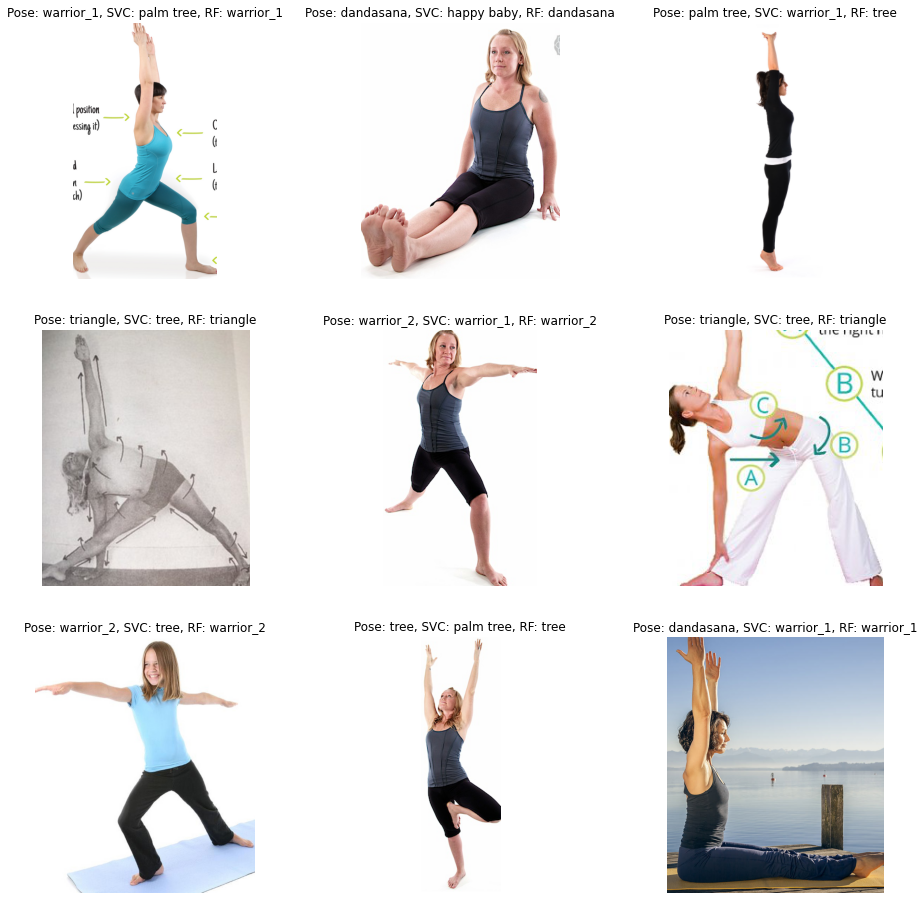

In [21]:
# VISUALIZING 9 OF SVC FAILED PREDICTIONS, needs refactoring if < than 9 errors.

fig = plt.figure(figsize=(16, 16))
columns = 3
rows = 3

for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(images_ordered[SVC_false_pred[i]])

    label_i = labels[SVC_false_pred[i]]
    pred_svc_i = decoded_SVC_predictions[SVC_false_pred[i]]
    pred_rf_i = decoded_RF_predictions[SVC_false_pred[i]]

    plt.title(f'Pose: {label_i}, SVC: {pred_svc_i}, RF: {pred_rf_i}')
    plt.axis('off')

plt.show()

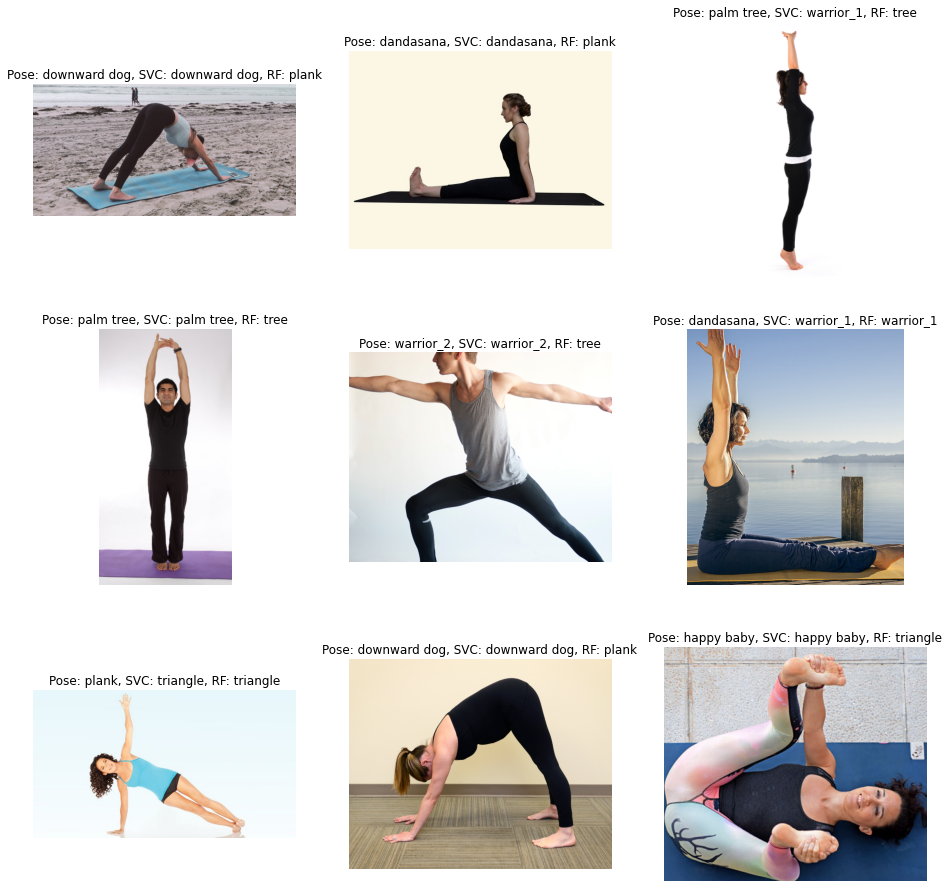

In [22]:
# VISUALIZING 9 OF SVC FAILED PREDICTIONS

fig = plt.figure(figsize=(16, 16))

for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(images_ordered[RF_false_pred[i]])

    label_i = labels[RF_false_pred[i]]
    pred_svc_i = decoded_SVC_predictions[RF_false_pred[i]]
    pred_rf_i = decoded_RF_predictions[RF_false_pred[i]]

    plt.title(f'Pose: {label_i}, SVC: {pred_svc_i}, RF: {pred_rf_i}')
    plt.axis('off')

plt.show()